<font size="+3"><strong>Earthquake Damage in Kavrepalanchok 🇳🇵</strong></font>

In [2]:
__author__ = "Donald Ghazi"
__email__ = "donald@donaldghazi.com"
__website__ = "donaldghazi.com"

In this project, I'll build a classification model to predict building damage for the district of [Kavrepalanchok](https://en.wikipedia.org/wiki/Kavrepalanchok_District).

In [15]:
import sqlite3
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Connect

First I will connect to the `sqlite` database.

In [4]:
%reload_ext sql
%sql sqlite:////home/jovyan/nepal.sqlite

'Connected: @/home/jovyan/nepal.sqlite'

I want to see which districts are represented in the `id_map` table. I can do this by determining the unique values in the **`district_id`** column.

In [5]:
%%sql
SELECT distinct(district_id)
FROM id_map

 * sqlite:////home/jovyan/nepal.sqlite
Done.


district_id
1
2
3
4


From my previous projects, I already know that the district ID for Gorkha is `4` and Ramechhap is `2`. Of the remaining districts, Kavrepalanchok is the one with the largest number of observations in the `id_map` table. So in order to find the district ID for Kavrepalanchok, I need to calculate the number of observations in the `id_map` table associated with district `1`.

In [6]:
%%sql
SELECT *
FROM id_map
WHERE district_id = 1
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


household_id,building_id,vdcmun_id,district_id
5601,56,7,1
6301,63,7,1
9701,97,7,1
9901,99,7,1
11501,115,7,1


In [7]:
%%sql
SELECT count(*)
FROM id_map
WHERE district_id = 1

 * sqlite:////home/jovyan/nepal.sqlite
Done.


count(*)
36112


I can calculate the number of observations in the `id_map` table associated with district `3`.

In [8]:
%%sql
SELECT count(*)
FROM id_map
WHERE district_id = 3

 * sqlite:////home/jovyan/nepal.sqlite
Done.


count(*)
82684


I can now join the unique building IDs from Kavrepalanchok in `id_map`, all the columns from  `building_structure`, and the **`damage_grade`** column from `building_damage`, limiting. I'm going to rename the **`building_id`** column in `id_map` as **`b_id`** and limit my results to the first five rows of the new table.

In [9]:
%%sql
SELECT distinct(i.building_id) AS b_id,
       s.*,
       d.damage_grade
FROM id_map AS i
JOIN building_structure AS s ON i.building_id = s.building_id
JOIN building_damage AS d ON i.building_id = d.building_id
WHERE district_id = 3
LIMIT 5

 * sqlite:////home/jovyan/nepal.sqlite
Done.


b_id,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
87473,87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
87479,87479,1,0,12,328,7,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5
87482,87482,2,1,23,427,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87491,87491,2,1,12,427,14,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87496,87496,2,0,32,360,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5


## Import

I will need to write `wrangle` function that will use the query I created in the previous task to create a DataFrame. In addition my function should:

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` should be encoded as `1`. All other buildings should be encoded at `0`. 
2. Drop any columns that could cause issues with leakage or multicollinearity in my model.

In [10]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
            s.*,
            d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 3

    """
    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # Drop high-linearlity / redundant column
    drop_cols.append("building_id")
    
    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [11]:
# Use my wrangle function to query the database at "/home/jovyan/nepal.sqlite" and return my cleaned results
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87496,32,360,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1


## Explore

To see if the classes in this dataset are balanced, I can create a bar chart with the normalized value counts from the `"severe_damage"` column.

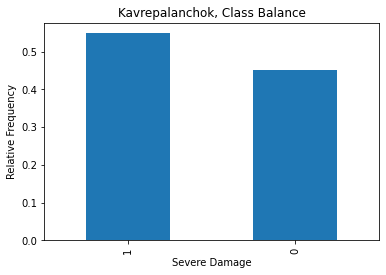

In [12]:
# Plot value counts of "severe_damage"
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Severe Damage", ylabel="Relative Frequency", title="Kavrepalanchok, Class Balance"); # Label the x-axis "Severe Damage" & y-axis "Relative Frequency", title "Kavrepalanchok, Class Balance"

To see if there is a relationship between the footprint size of a building and the damage it sustained in the earthquake, I can use seaborn to create a boxplot that shows the distributions of the `"plinth_area_sq_ft"` column for both groups in the `"severe_damage"` column. 

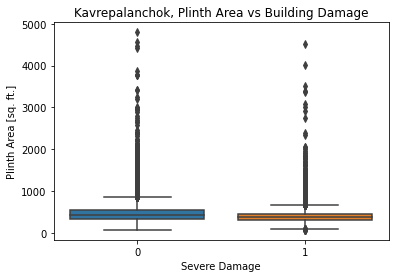

In [16]:
# Create boxplot
sns.boxplot(x="severe_damage", y="plinth_area_sq_ft", data=df)
# Label axes
plt.xlabel("Severe Damage")                  # Label x-axis "Severe Damage"
plt.ylabel("Plinth Area [sq. ft.]")          # Label y-axis "Plinth Area [sq. ft.]"
plt.title("Kavrepalanchok, Plinth Area vs Building Damage"); # Title "Kavrepalanchok, Plinth Area vs Building Damage"

To see if buildings with certain roof types are more likely to suffer severe damage, I can create a pivot table of `df` where the index is `"roof_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [17]:
roof_pivot = pd.pivot_table(
    df, index="roof_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")
roof_pivot

,severe_damage
roof_type,
RCC/RB/RBC,0.040715
Bamboo/Timber-Heavy roof,0.569477
Bamboo/Timber-Light roof,0.604842


## Split

In [18]:
# Create my feature matrix X and target vector y. My target is "severe_damage"
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (76533, 11)
y shape: (76533,)


In [19]:
# Divide my dataset into training and validation sets using a randomized split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42              # My validation set should be 20% of my data
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


# Build Model

## Baseline

In [20]:
# Calculate the baseline accuracy score for my model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## Iterate

In [21]:
# Create a model model_lr that uses logistic regression to predict building damage
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)

# Fit model to training data
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [22]:
# Calculate training and validation accuracy score for model_lr
lr_train_acc = model_lr.score(X_train, y_train)
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6513735994512135
Logistic Regression, Validation Accuracy Score: 0.6530998889397008


Perhaps a decision tree model will perform better than logistic regression, but I need to first find what is the best hyperparameter value for `max_depth`.

In [23]:
# Create a for loop to train and evaluate the model "model_dt" at all depths from 1 to 15
depth_hyperparams = range(1, 16)

# Create empty lists for training and validation accuracy scores
training_acc = []
validation_acc = []

for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    model_dt = make_pipeline(
        OrdinalEncoder(), 
        DecisionTreeClassifier(max_depth=d, random_state=42))
    
    # Fit model to training data
    model_dt.fit(X_train, y_train)
    
    # Calculate training accuracy score and append to `training_acc`
    training_acc.append(model_dt.score(X_train, y_train))
    # Calculate validation accuracy score and append to `training_acc`
    validation_acc.append(model_dt.score(X_val, y_val))
    
print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])

Training Accuracy Scores: [0.6303041191650606, 0.6303041191650606, 0.642292490118577]
Validation Accuracy Scores: [0.6350035931273273, 0.6350035931273273, 0.6453909975828053]


I can use the values in `training_acc` and `validation_acc` to plot the validation curve for `model_dt`.

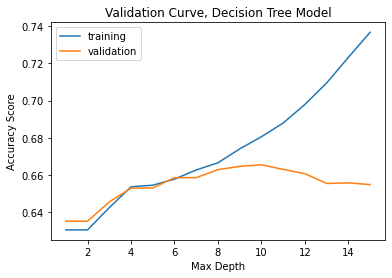

In [24]:
# Plot `depth_hyperparams`, `training_acc`
plt.plot(depth_hyperparams, training_acc, label="training")
plt.plot(depth_hyperparams, validation_acc, label="validation")
plt.xlabel("Max Depth")          #  Label x-axis "Max Depth"
plt.ylabel("Accuracy Score")     #  Label y-axis "Accuracy Score"
plt.title("Validation Curve, Decision Tree Model") # Title "Validation Curve, Decision Tree Model"
plt.legend();

I can further build and train a new decision tree model `final_model_dt`, using the value for `max_depth` that yielded the best validation accuracy score in my plot above. 

In [25]:
final_model_dt = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth = 10, random_state = 42)
)

final_model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
Building with Central Courtyard     9
H-shape                            10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
Adobe/mud                2
Brick, cement mortar     3
RC, engineered           4
Brick, mud mortar        5
Stone, cement mortar     6
RC, non-engineered       7
Timber                   8
Other                    9
Bamboo                  10
Stone                   11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

## Evaluate

I want to see how does my model perform on the test set.

In [26]:
# Read the CSV file "data/kavrepalanchok-test-features.csv" into the DataFrame X_test
X_test = pd.read_csv("data/kavrepalanchok-test-features.csv", index_col="b_id")
y_test_pred = final_model_dt.predict(X_test)    # Use final_model_dt to generate a list of test predictions y_test_pred
pd.Series(y_test_pred)
y_test_pred[:5]

array([1, 1, 1, 1, 0])

# Communicate Results

To see what most important features for `final_model_dt` are, I can create a Series Gini `feat_imp`, where the index labels are the feature names for my dataset and the values are the feature importances for my model. The Series is should be sorted from smallest to largest feature importance. 

In [27]:
features = model_lr.named_steps["onehotencoder"].get_feature_names()
importances = model_lr.named_steps["logisticregression"].coef_[0]
feat_imp = pd.Series(np.exp(importances), index=features).sort_values()
feat_imp.head()

foundation_type_RC                     0.430515
superstructure_Brick, cement mortar    0.550657
roof_type_RCC/RB/RBC                   0.566908
ground_floor_type_RC                   0.599185
superstructure_RC, non-engineered      0.616918
dtype: float64

Then, I can create a horizontal bar chart of `feat_imp`.

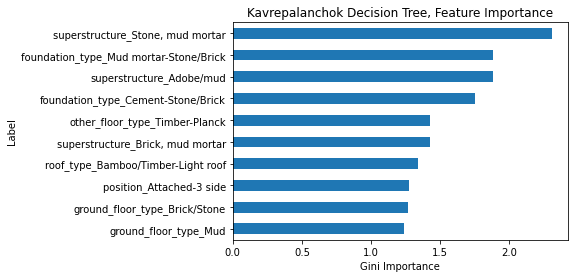

In [28]:
# Create horizontal bar chart of feature importances
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")     # Label x-axis "Gini Importance"
plt.ylabel("Label")               # Label y-axis "Label"
plt.title("Kavrepalanchok Decision Tree, Feature Importance");   # Title "Kavrepalanchok Decision Tree, Feature Importance"